# Step 1: Choosing SVM (Support Vector Machine) as one of the three classifiers

---


**Justification :** SVM is used to classify data by finding the optimal decision boundary that maximally separates different classes. SVM is good with high dimensional data and is memory efficient as well. SVM supports different kernels as well which performs good on linear and non-linear seperable data.SVM is also effective to small to medium sized dataset. SVMs also handle outliers very well due to the focus on support vectors, which are the points near the decision boundary

# Step 2: Model evaluation of SVM

**Understanding data through scatter plots :**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the diabetes dataset
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

# Dropping the label Outcome which is class attribute in the dataset
data = df.drop('Outcome', axis=1)
labels = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=0)

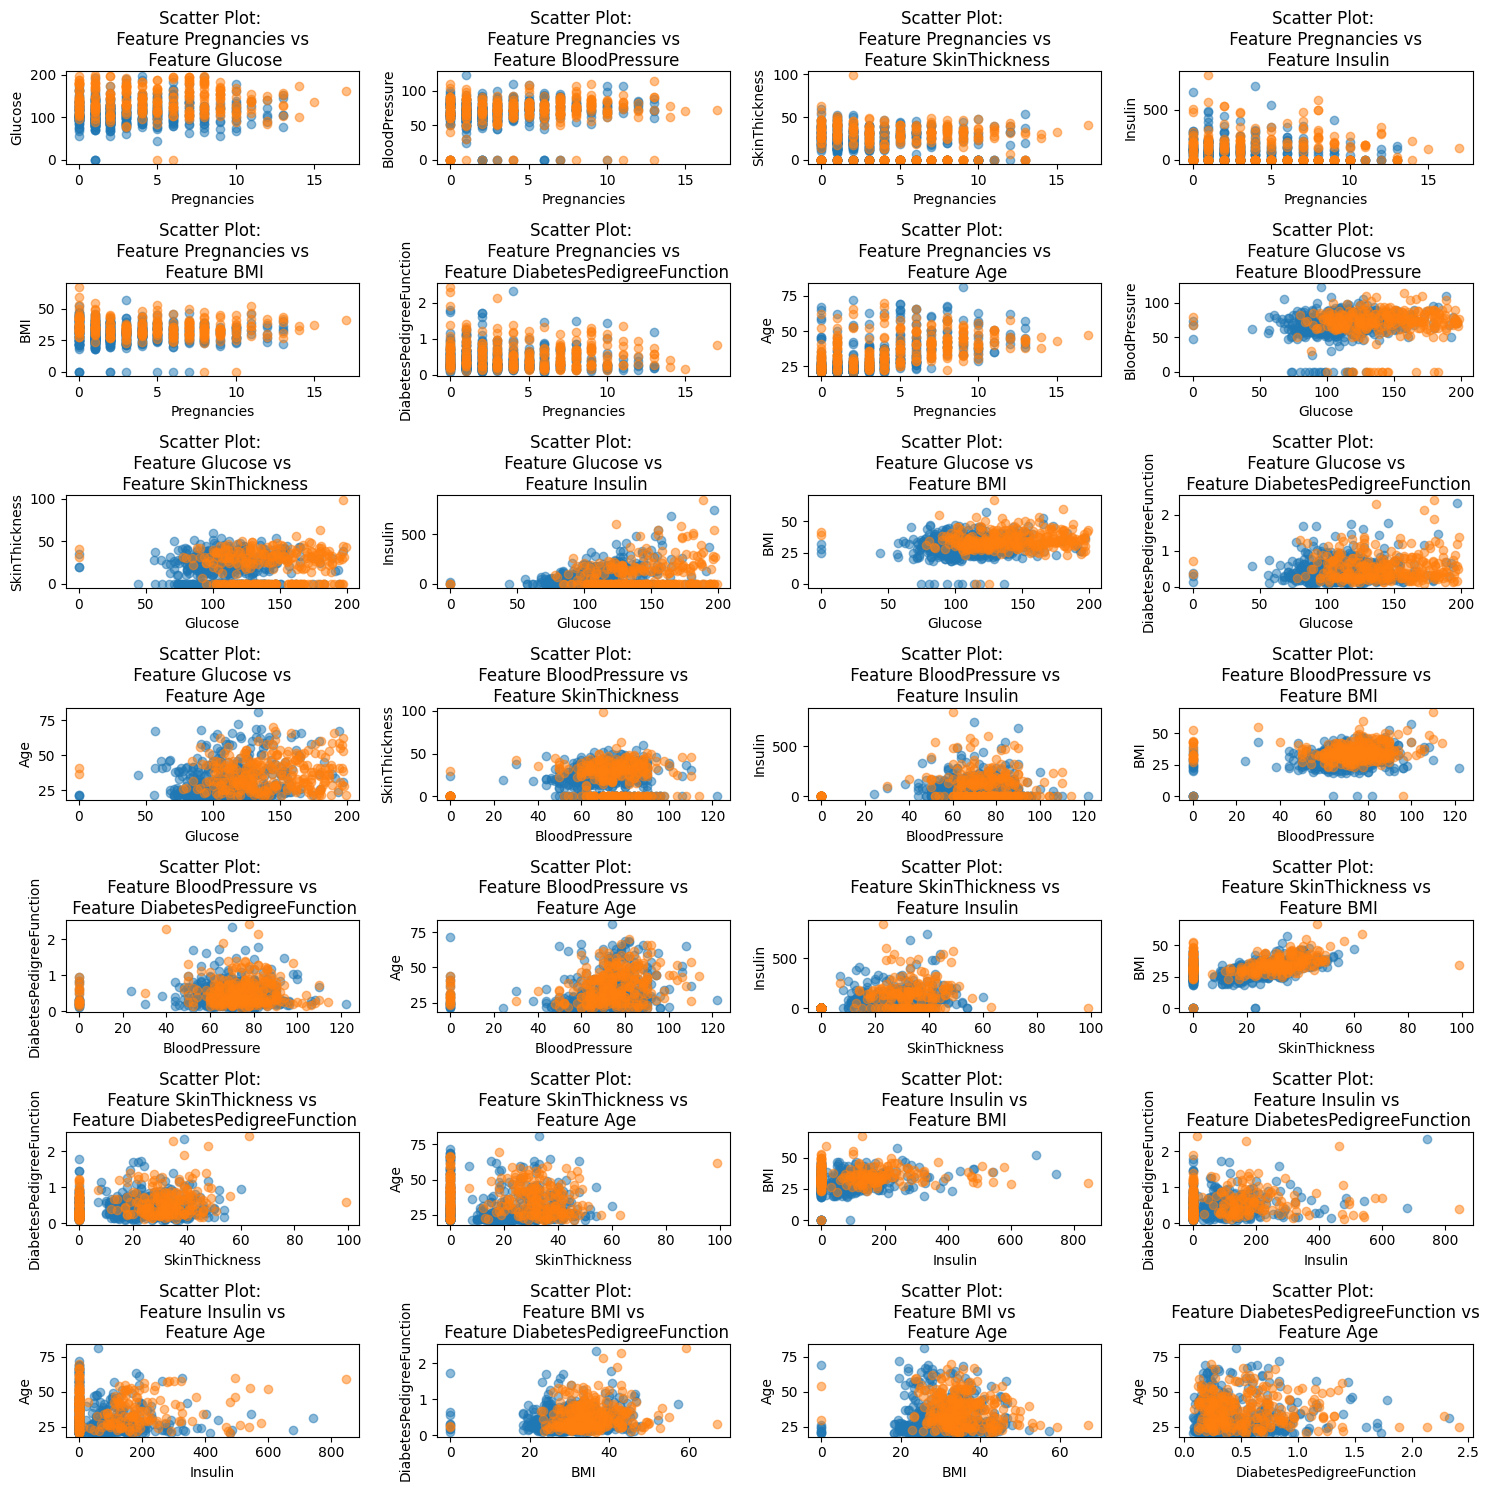

In [2]:
from textwrap import wrap
num_features = len(data.columns)

# Create pairs of features for scatter plot
attribute_pairs = [(i, j) for i in range(num_features) for j in range(i+1, num_features)]

# Configuring sub plot
num_pairs = len(attribute_pairs)
num_rows = num_pairs // 4
num_cols = 4 if num_pairs % 4 == 0 else 3

class_column = 'Outcome'

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Display scatter plots for each attribute pair
for (attr1, attr2), ax in zip(attribute_pairs, axes.flatten()):
    ax.scatter(df[df[class_column] == 0].iloc[:, attr1], df[df[class_column] == 0].iloc[:, attr2], alpha=0.5, label='Class 1')
    ax.scatter(df[df[class_column] == 1].iloc[:, attr1], df[df[class_column] == 1].iloc[:, attr2], alpha=0.5, label='Class 2')
    ax.set_title(f'Scatter Plot: \n Feature {df.columns[attr1]} vs \n Feature {df.columns[attr2]}', wrap=True)
    ax.set_xlabel(f'{df.columns[attr1]}')
    ax.set_ylabel(f'{df.columns[attr2]}')

# Show plot
plt.tight_layout()
plt.show()

**Observation:**  Most of the scatter plots are well clustered indicating strong dependency. There are few outliers as well in the data. On a large view, the data is not linearly seperable and hence we will go ahead with implementation of non-linear SVM model just by observing the scatter plots.

**Implementation of cross validation to evaluate a non-linear rbf SVM model :**

In [9]:
# Standardizing and normalizing features can have a positive impact on SVM performance
# hence scaling the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=0)

# Initialize an SVM classifier with rbf kernel chosen
svm_classifier = SVC(kernel='rbf', gamma='auto', probability=True)

# Fit the model with training data
svm_classifier.fit(X_train, y_train)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5)

# Display cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

# Predict with the initialized svm model
y_pred_dt = svm_classifier.predict(X_test)

# Generate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_dt)
roc_auc = roc_auc_score(y_test, svm_classifier.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")


Cross-Validation Scores: [0.64935065 0.64935065 0.63636364 0.63636364 0.64473684]
Mean Accuracy: 0.6432330827067669
Standard Deviation: 0.00585643443975174
Accuracy: 0.66
ROC-AUC: 0.39


**Plotting Learning and ROC Curves for rbf SVM model:**

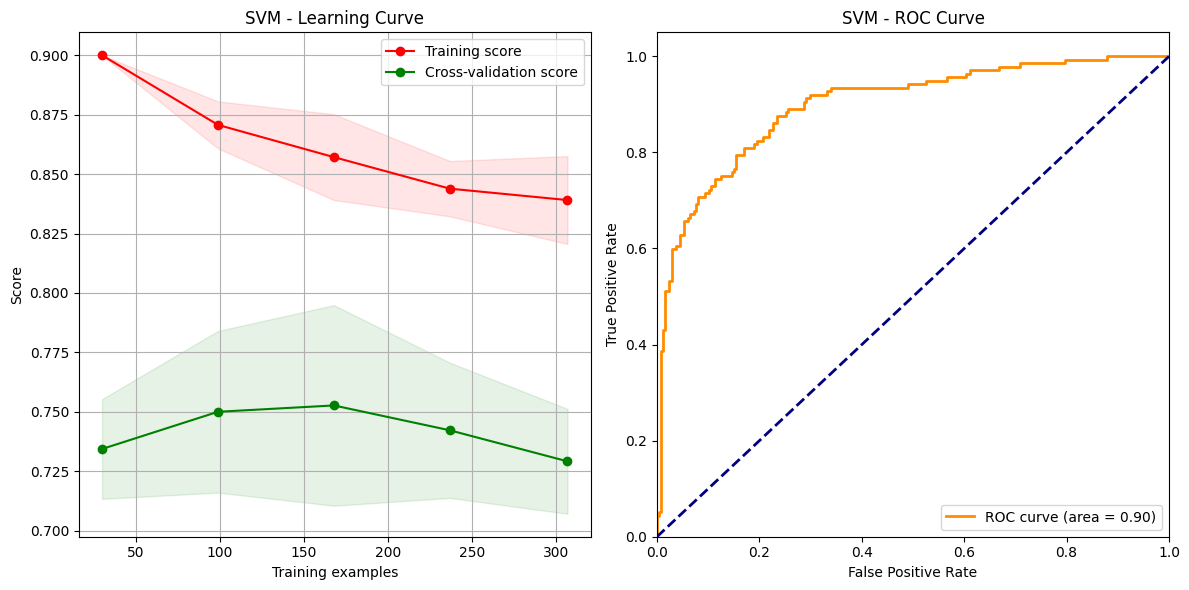

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_learning_curve_svm_roc(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12, 6))

    # Plotting Learning Curve
    plt.subplot(1, 2, 1)
    plt.title(title + " - Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

    # Plotting ROC Curve
    plt.subplot(1, 2, 2)
    plt.title(title + " - ROC Curve")

    # Fit the estimator model
    estimator.fit(X, y)

    # Calling decision function on estimator
    y_score = estimator.decision_function(X)

    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

title_svm = "SVM"
plot_learning_curve_svm_roc(svm_classifier, title_svm, X_train_scaled, y_train, cv=5)


**Curve Observation :** Here the training score is more than the cross validation score which indicates potential overfitting. The curve for true positive rate is much higher indicating over fitting. Hyper parameter tuning is required to address issue of over fitting.

# Step 3 : Improving performance

**Implementing hyper parameter tuning to find best parameters to improve performance :**

1.   Using StratifieldKFold to ensure each fold has same same class distribution as the entire dataset
2.   Hyper parameter tuning for parameters - kernel and regularized parameter C



In [10]:
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# Example with GridSearchCV for Decision Tree hyperparameters
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 0.5, 1]}

svm_classifier = SVC(probability=True)
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best kernel
best_kernel = grid_search.best_params_['kernel']
best_C = grid_search.best_params_['C']
best_svm_classifier = grid_search.best_estimator_

print("Best kernel:", best_kernel)
print("Best C:", best_C)


Best kernel: linear
Best C: 0.01


In [11]:
# Split the data into training and testing sets with 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

# Train the classifier on the entire training set
best_svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test)

# Evaluate the performance on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")


Accuracy on the test set: 0.81


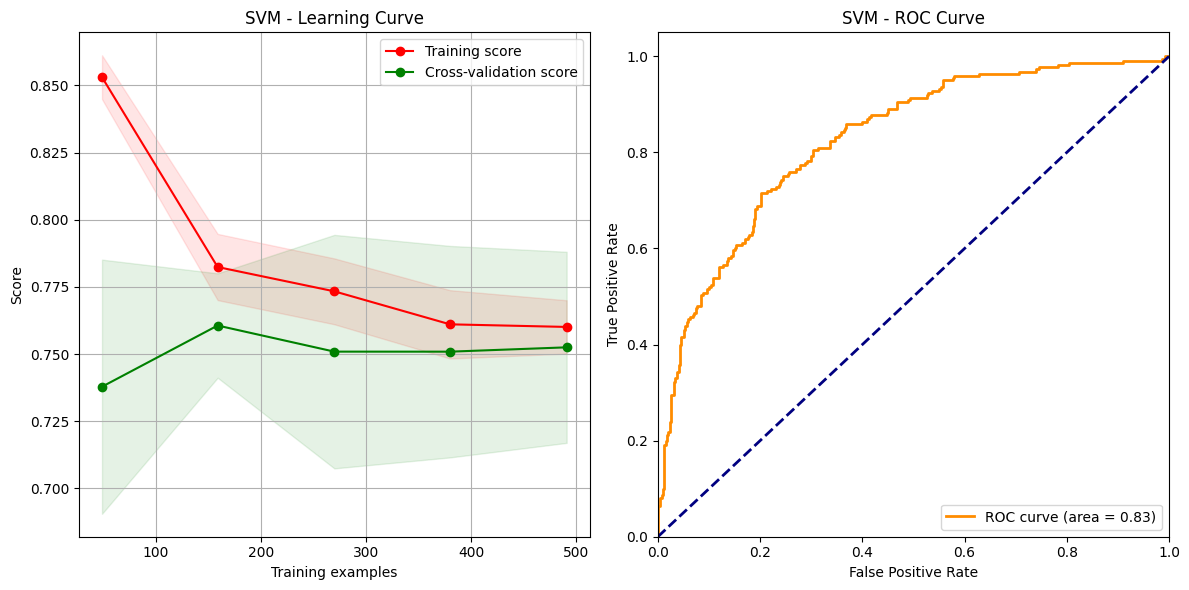

In [12]:
# Plotting curves again to check performance
title_svm = "SVM"
plot_learning_curve_svm_roc(best_svm_classifier, title_svm, X_train, y_train, cv=5)

# Step 4 : Conclusion

It is observed from the learning curve that the training score is initially higher than the validation score, but they converge and become close to each as size of training dataset is increased. It indicates that the model was initially overfitting but later the performance improved. As the dataset size increased, the overfitting reduced as the model started to generalize to the validation set. This
is possible because model starts encountering more diverse examples and its ability to generalize improves.

Due to convergence the model has achieved a good balance between fitting the training data and generalizing to new and unseen data.


**Project Achievement :**

Successfully performed model evaluation of SVM model to solve a classification task on diabetes dataset. The initial scores obtained were -

- Cross-Validation Scores: [0.64935065 0.64935065 0.63636364 0.63636364
0.64473684]
- Mean Accuracy: 0.6432330827067669
- Standard Deviation: 0.00585643443975174
- Accuracy: 0.66
- ROC-AUC: 0.39

 With implementation of cross validation and hyper parameter tuning, the performance was improved and the accuracy was improved to 81%. With initial evaluation of scatter plots, SVM with rbf kernel was implemented which gave low performance and overfitting of the data. With help of GridSearchCV fine-tuning of parameters was performed and best performing model with kernel as Linear and C as 0.01 was used. This helped in performance improvement and solving the issue of overfitting. The cross validation score also increased to ~0.75 and the test score to ~0.76 which shows promising performance.

**Drawbacks :**
Since data had noise and outliers, the model could have been influenced by it as SVM model is sensitive to noise. Data was not pre-processed which a drawback in model performance.

**Possibility of Improvement :**

Data pre-processing and cleaning was not performed on the data which can lead to good performance. Using feature engineering can help improve the performance of model even more. Some other models can also be used like Random Forest which can provide more generalization.








